In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning import Trainer, seed_everything

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
import skipgrammar.datasets as dset
from skipgrammar.models.lightning import SGNS

In [5]:
seed_everything(7)

7

## Data

In [6]:
%%time

variant = 'ml-dev-small'

movielens_dataset = dset.MovieLensUserItemDataset(variant)

CPU times: user 125 ms, sys: 20.6 ms, total: 145 ms
Wall time: 150 ms


In [7]:
movielens_dataset.df.groupby('user').size().describe()

count     610.000000
mean      147.990164
std       216.882426
min        12.000000
25%        34.000000
50%        68.000000
75%       159.000000
max      2132.000000
dtype: float64

In [8]:
movielens_dataloader = DataLoader(movielens_dataset, batch_size=32, num_workers=6, drop_last=True)

In [9]:
model = SGNS(
    num_embeddings=movielens_dataset.num_items, embedding_dim=100,
    weights=None, num_negative_samples=5, nn_embedding_kwargs={'sparse': True},
    learning_rate=0.003
)

## Training

In [10]:
tb_logger = pl_loggers.TensorBoardLogger('logs/', name=f'sgns-{variant}')

### Dry Run

In [11]:
trainer = Trainer(logger=tb_logger, fast_dev_run=True)

Running in fast_dev_run mode: will run a full train, val and test loop using a single batch
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [12]:
trainer.fit(model, train_dataloaders=movielens_dataloader)


  | Name              | Type      | Params
------------------------------------------------
0 | embeddings        | Embedding | 974 K 
1 | target_embeddings | Embedding | 974 K 


1

### Train

In [13]:
trainer = Trainer(logger=tb_logger, max_epochs=5, progress_bar_refresh_rate=200)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


In [14]:
trainer.fit(model, train_dataloaders=movielens_dataloader)


  | Name              | Type      | Params
------------------------------------------------
0 | embeddings        | Embedding | 974 K 
1 | target_embeddings | Embedding | 974 K 


1

In [15]:
lu = movielens_dataset.id_metadata
len(lu)

9742

In [16]:
embeddings = model.embeddings.weight.detach().cpu().numpy()
embeddings.shape

(9742, 100)

In [17]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [18]:
num_embeddings = 50
rand_embedding_ids = np.random.randint(0, len(embeddings), num_embeddings)
tsne = TSNE()
embeddings_reduced = tsne.fit_transform(embeddings[rand_embedding_ids, :])
embeddings_reduced.shape

(50, 2)

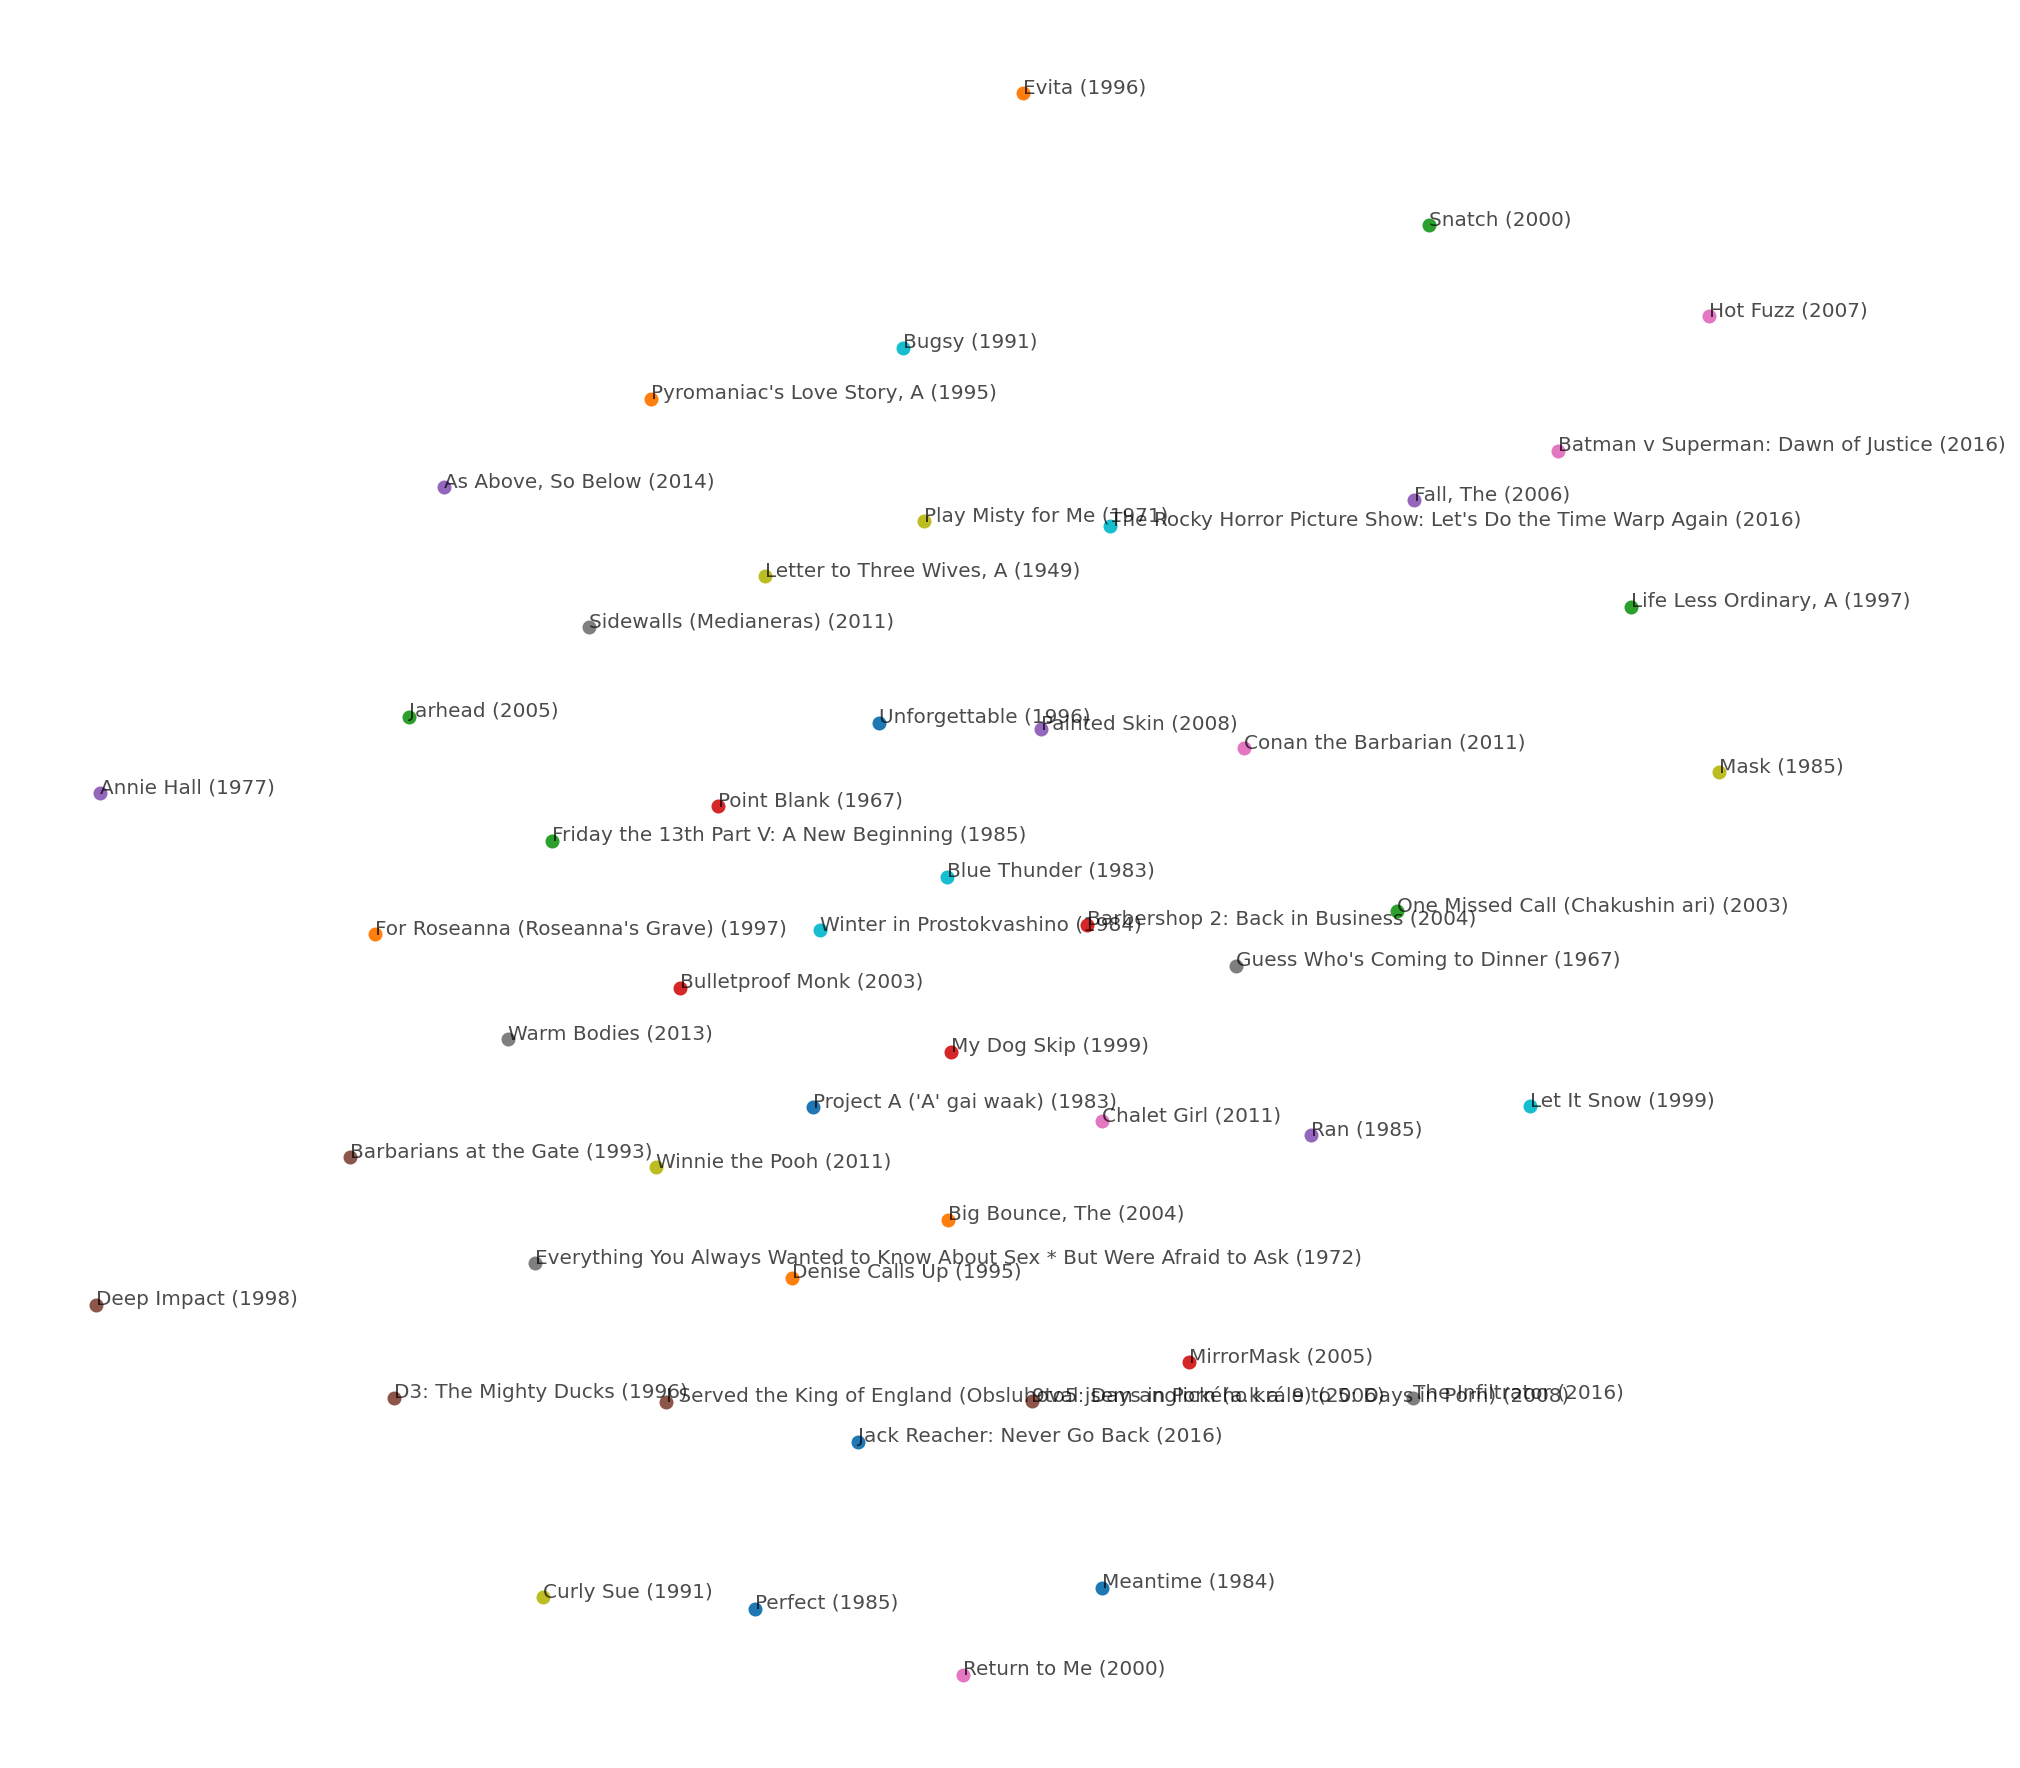

In [19]:
fig, ax = plt.subplots(figsize=(16, 16))
for i, embedding_id in enumerate(rand_embedding_ids):
    plt.scatter(embeddings_reduced[i, 0], embeddings_reduced[i, 1])
    plt.annotate(lu[embedding_id].get('title'), (embeddings_reduced[i, 0], embeddings_reduced[i, 1]), alpha=0.7)
plt.axis('off');